In [1]:
'''
TASK 4:

Develop a hand gesture recognition model that can accurately identify and 
classify different hand gestures from image or video data, 
enabling intuitive human-computer interaction and gesture-based control systems.

'''

'\nTASK 4:\n\nDevelop a hand gesture recognition model that can accurately identify and \nclassify different hand gestures from image or video data, \nenabling intuitive human-computer interaction and gesture-based control systems.\n\n'

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

In [3]:
#After downloading the dataset and extraction, define the path
PATH = r'C:\Users\ASUS\ProdigyInfoTech Projects\leapGestRecog'
print(os.listdir(PATH))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [4]:
len(os.listdir(r'C:\Users\ASUS\ProdigyInfoTech Projects\leapGestRecog\00'))

10

In [5]:
#Function to get item count of each folder in folder 00
def get_folder_item_count(folder_path):
    item_count = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        item_count += len(dirnames) + len(filenames)
    return item_count

def calculate_folder_item_counts(root_folder):
    folder_item_counts = {}
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            folder_item_counts[folder_name] = get_folder_item_count(folder_path)
    return folder_item_counts


root_folder = r'C:\Users\ASUS\ProdigyInfoTech Projects\leapGestRecog\00'  
folder_item_counts = calculate_folder_item_counts(root_folder)
for folder, count in folder_item_counts.items():
    print(f"Folder: {folder}, Item Count: {count}")
    

Folder: 01_palm, Item Count: 202
Folder: 02_l, Item Count: 200
Folder: 03_fist, Item Count: 200
Folder: 04_fist_moved, Item Count: 200
Folder: 05_thumb, Item Count: 200
Folder: 06_index, Item Count: 200
Folder: 07_ok, Item Count: 200
Folder: 08_palm_moved, Item Count: 200
Folder: 09_c, Item Count: 200
Folder: 10_down, Item Count: 200


In [6]:
# Define the root directory of dataset
root_dir = r'C:\Users\ASUS\ProdigyInfoTech Projects\leapGestRecog'
train_dir = r'C:\Users\ASUS\ProdigyInfoTech ProjectsleapGestRecog\train'
val_dir = r'C:\Users\ASUS\ProdigyInfoTech ProjectsleapGestRecog\val'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Traverse the directory
for person_folder in os.listdir(root_dir):
    person_folder_path = os.path.join(root_dir, person_folder)
    if os.path.isdir(person_folder_path):
        for class_folder in os.listdir(person_folder_path):
            class_folder_path = os.path.join(person_folder_path, class_folder)
            if os.path.isdir(class_folder_path):
                for img in os.listdir(class_folder_path):
                    img_path = os.path.join(class_folder_path, img)
                    if os.path.isfile(img_path):
                        image_paths.append(img_path)
                        labels.append(class_folder)  # Use class folder name as the label

# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Helper function to create hard links
def create_hard_links(paths, labels, dest_dir):
    for img_path, label in zip(paths, labels):
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        hard_link_path = os.path.join(label_dir, os.path.basename(img_path))
        if not os.path.exists(hard_link_path):
            os.link(img_path, hard_link_path)

# Create hard links for training and validation sets
create_hard_links(train_paths, train_labels, train_dir)
create_hard_links(val_paths, val_labels, val_dir)

print("Dataset preparation complete with hard links.")


Dataset preparation complete with hard links.


In [7]:
#Function to verifyy directory's structure
def verify_structure(directory):
    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_folder_path):
            images = os.listdir(class_folder_path)
            print(f'Class {class_folder} has {len(images)} images.')

print("Verifying training set:")
verify_structure(train_dir)

print("\nVerifying validation set:")
verify_structure(val_dir)


Verifying training set:
Class 01_palm has 1600 images.
Class 02_l has 1600 images.
Class 03_fist has 1600 images.
Class 04_fist_moved has 1600 images.
Class 05_thumb has 1600 images.
Class 06_index has 1600 images.
Class 07_ok has 1600 images.
Class 08_palm_moved has 1600 images.
Class 09_c has 1600 images.
Class 10_down has 1600 images.

Verifying validation set:
Class 01_palm has 719 images.
Class 02_l has 732 images.
Class 03_fist has 712 images.
Class 04_fist_moved has 706 images.
Class 05_thumb has 720 images.
Class 06_index has 731 images.
Class 07_ok has 721 images.
Class 08_palm_moved has 708 images.
Class 09_c has 716 images.
Class 10_down has 717 images.


In [8]:
# Define function to load and preprocess images
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [180, 180])  
    img = tf.image.per_image_standardization(img)
    return img

def load_and_label_image(img_path, label):
    img = load_image(img_path)
    return img, label

In [9]:
# Create datasets for training and validation
def create_dataset(img_paths, labels, batch_size=128):
    label_to_index = {label: index for index, label in enumerate(set(labels))}
    labels = [label_to_index[label] for label in labels]

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(load_and_label_image)
    dataset = dataset.shuffle(buffer_size=len(img_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [10]:
train_dataset = create_dataset(train_paths, train_labels)
val_dataset = create_dataset(val_paths, val_labels)

In [11]:
# Print dataset info
for images, labels in train_dataset.take(1):
    print("Train batch - Images:", images.shape, "Labels:", labels)
for images, labels in val_dataset.take(1):
     print("Validation batch - Images:", images.shape, "Labels:", labels)

Train batch - Images: (128, 180, 180, 3) Labels: tf.Tensor(
[3 8 2 3 9 2 4 8 1 2 7 7 6 5 7 9 3 8 6 1 3 4 3 6 8 5 4 2 8 0 3 2 6 0 2 7 0
 3 7 3 2 3 2 2 0 9 0 4 5 0 7 5 1 4 6 4 3 7 5 1 9 7 3 0 1 2 8 6 7 1 4 6 6 7
 0 0 0 5 4 2 3 5 1 5 2 2 9 2 1 1 3 2 3 3 6 6 5 4 0 9 2 7 8 5 8 6 1 6 1 2 4
 5 1 3 9 4 4 6 2 0 2 3 0 4 2 5 4 9], shape=(128,), dtype=int32)
Validation batch - Images: (128, 180, 180, 3) Labels: tf.Tensor(
[1 9 1 9 9 2 3 6 0 6 5 6 3 1 3 9 4 6 0 8 9 3 9 6 5 1 1 2 3 1 1 6 0 7 4 4 5
 7 3 8 8 0 6 3 7 0 1 5 5 9 3 0 7 8 8 1 8 2 3 4 1 8 0 1 3 3 6 6 7 2 2 8 4 7
 7 6 9 2 7 3 3 0 3 7 8 3 8 9 2 0 6 3 6 5 0 2 9 8 4 6 9 1 8 2 8 5 9 2 2 1 1
 3 9 9 1 8 5 9 0 2 7 2 6 8 7 7 2 6], shape=(128,), dtype=int32)


In [12]:
# Making the model

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(set(train_labels)), activation='softmax') 
])


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [16]:
#Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  
    verbose=1
)

Epoch 1/10
125/125 [==============================] - 48s 198ms/step - loss: 0.3439 - accuracy: 0.8966 - val_loss: 0.0134 - val_accuracy: 0.9977
Epoch 2/10
125/125 [==============================] - 35s 190ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0039 - val_accuracy: 0.9987
Epoch 3/10
125/125 [==============================] - 34s 192ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 4/10
125/125 [==============================] - 35s 196ms/step - loss: 8.0606e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 5/10
125/125 [==============================] - 36s 190ms/step - loss: 1.9357e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 6/10
125/125 [==============================] - 35s 191ms/step - loss: 1.1676e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 7/10
125/125 [==============================] - 36s 192ms/step - loss: 8.1175e-06 - accuracy: 1.0000 - val_loss:

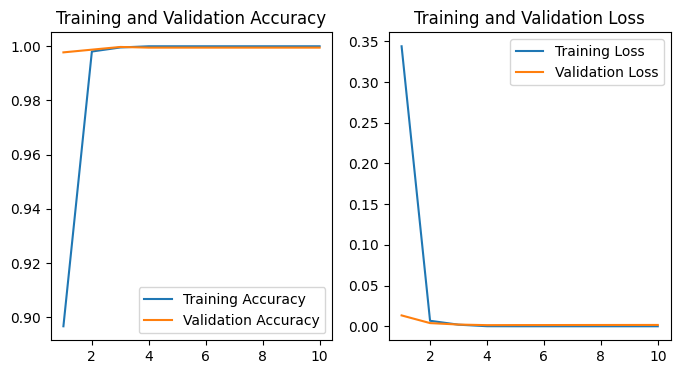

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()